## Packages

In [1]:
# Initial packages:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"


## Generate Training Data:

Generate the training data for the emissivity-temperature relation. The ideal mathematical form of the emissivity-temperature relation is:

$$\varepsilon(T)=\left[1+5 \sin \left(\dfrac{3 \pi}{200} T\right)+\exp (0.02 T)\right] \times 10^{-4}$$

the training data is generated by adding a zero-mean Gaussian noise to the analytical relation. The Gaussian noise follows the normal distribution:

$$\epsilon \sim N(\mu, \sigma^2)$$

where $\mu=0$, and $\sigma=0.3$.

The data used for training MLP model is sampled within range:  $T \in[0,60]$,


In [2]:
n_data = 80
X_theo=np.linspace(0,60,n_data)
Y_theo = (1 + 5*np.sin(3*np.pi/200*X_theo) + np.exp(0.02*X_theo) )

np.random.seed(5)
X_total=np.linspace(0,60,n_data)
# X_total = np.random.uniform(0,60,n_data)
Y_exp = (1 + 5*np.sin(3*np.pi/200*X_total) + np.exp(0.02*X_total) + np.random.normal(0, 0.3, n_data) )

In [3]:
# plot the training data
fig, ax=plt.subplots(figsize = (5,3.7))
l_theo = ax.plot(X_theo,Y_theo,lw=3, color='k',linestyle='--')
l_data_01 = ax.scatter(X_total,Y_exp,color='C1')

ax.set_ylabel(r" ${\varepsilon(T)} \times 10^4$ ")
ax.set_xlabel(r" ${T}$ ")
ax.legend(handles=[l_theo[0],l_data_01],
           labels=['Groud Truth','Noisy Data'],loc='best')
ax.grid()

<IPython.core.display.Javascript object>

## Training Sklearn Models

### RandomForest

In [4]:
from skl2onnx import __max_supported_opset__
print("Last supported opset:", __max_supported_opset__)

Last supported opset: 17


In [5]:
from sklearn.ensemble import RandomForestRegressor
RF_regressor = RandomForestRegressor(100, max_depth=6, max_leaf_nodes=9, max_samples=25)
RF_regressor.fit(X_total.reshape([-1,1]), Y_exp)

RandomForestRegressor(max_depth=6, max_leaf_nodes=9, max_samples=25)

In [6]:
Y_RF = RF_regressor.predict(X_total.reshape([-1,1]))
# plot the training data
fig, ax=plt.subplots(figsize = (5,3.7))
l_theo = ax.plot(X_theo,Y_theo,lw=3, color='k',linestyle='--')
l_ml = ax.plot(X_theo,Y_RF,lw=2.5, color='C0', alpha=0.85)
l_data_01 = ax.scatter(X_total,Y_exp,color='C1')

ax.set_ylabel(r" ${\varepsilon(T)} \times 10^4$ ")
ax.set_xlabel(r" ${T}$ ")
ax.legend(handles=[l_theo[0],l_data_01],
           labels=['Groud Truth','Noisy Data'],loc='best')
ax.grid()

<IPython.core.display.Javascript object>

### Support Vector Regression

In [9]:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RBF

k_SVR = 4.76**2 * RBF(length_scale=37.1) + WhiteKernel(noise_level=0.0826)
SVR_regressor = SVR(kernel='rbf', C=10, degree=5, gamma=0.0008, epsilon=0.001)
SVR_regressor.fit(X_total.reshape([-1,1]), Y_exp)

SVR(C=10, degree=5, epsilon=0.001, gamma=0.0008)

<IPython.core.display.Javascript object>


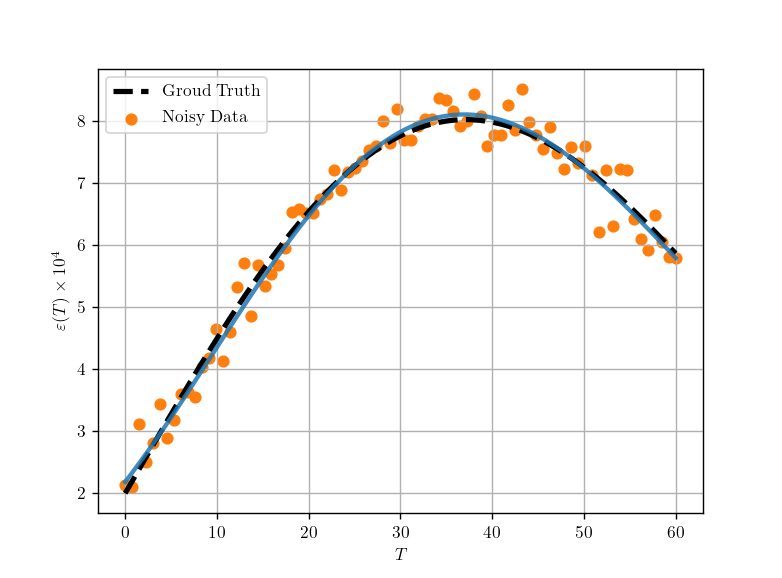

In [10]:
Y_SVR = SVR_regressor.predict(X_total.reshape([-1,1]))
# plot the training data
fig, ax=plt.subplots(figsize = (5,3.7))
l_theo = ax.plot(X_theo,Y_theo,lw=3, color='k',linestyle='--')
l_ml = ax.plot(X_theo,Y_SVR,lw=2.5, color='C0', alpha=0.85)
l_data_01 = ax.scatter(X_total,Y_exp,color='C1')

ax.set_ylabel(r" ${\varepsilon(T)} \times 10^4$ ")
ax.set_xlabel(r" ${T}$ ")
ax.legend(handles=[l_theo[0],l_data_01],
           labels=['Groud Truth','Noisy Data'],loc='best')
ax.grid()

### Gaussian Process

In [11]:
# kernel = 1.0 * ExpSineSquared(1.0) + WhiteKernel(1e-1)
# kernel = 1.0 * RBF(length_scale=5e-0, length_scale_bounds=(1e-0, 1e3)) + WhiteKernel(
#     noise_level=1e-2, noise_level_bounds=(1e-4, 1e1)
# )
kernel = 1.0 * RBF(length_scale=2e1, length_scale_bounds=(1e1, 1e3)) 
GPR_regressor = GaussianProcessRegressor(kernel=kernel)
GPR_regressor.fit(X_total.reshape([-1,1]), Y_exp)



GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=20))

<IPython.core.display.Javascript object>


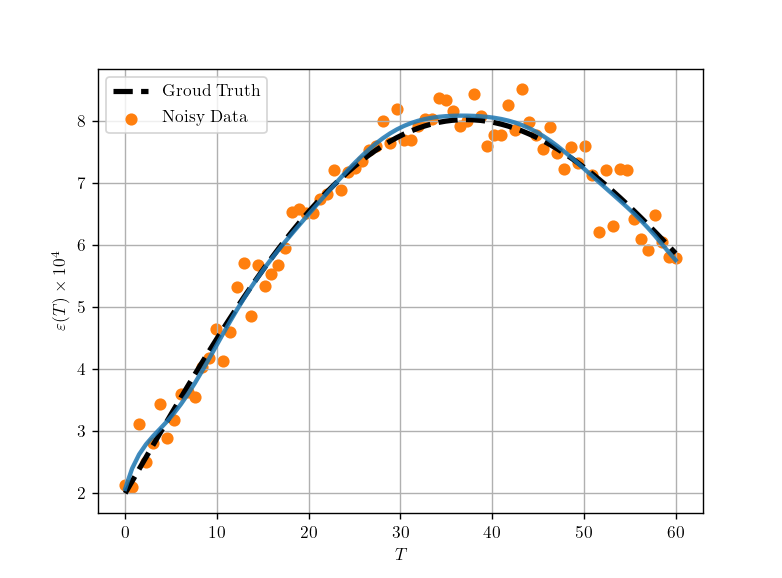

In [12]:
Y_GPR, std_GPR = GPR_regressor.predict(X_total.reshape([-1,1]), return_std=True)
# plot the training data
fig, ax=plt.subplots(figsize = (5,3.7))
l_theo = ax.plot(X_theo,Y_theo,lw=3, color='k',linestyle='--')
l_ml = ax.plot(X_theo,Y_GPR,lw=2.5, color='C0', alpha=0.85)
l_data_01 = ax.scatter(X_total,Y_exp,color='C1')

plt.fill_between(
    X_theo,
    Y_GPR - std_GPR,
    Y_GPR + std_GPR,
    color="tab:green",
    alpha=0.2,
)

ax.set_ylabel(r" ${\varepsilon(T)} \times 10^4$ ")
ax.set_xlabel(r" ${T}$ ")
ax.legend(handles=[l_theo[0],l_data_01],
           labels=['Groud Truth','Noisy Data'],loc='best')
ax.grid()

In [292]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, DoubleTensorType

initial_type = [('input', FloatTensorType([None, 1]))]
final_type = [('output', FloatTensorType([None, 1]))]

onx_RF = convert_sklearn(RF_regressor, initial_types=initial_type, final_types=final_type, target_opset=15)

with open("SKL_RF.onnx", "wb") as f:
    f.write(onx_RF.SerializeToString())
    
onx_SVR = convert_sklearn(SVR_regressor, initial_types=initial_type, final_types=final_type, target_opset=15)

with open("SKL_SVR.onnx", "wb") as f:
    f.write(onx_SVR.SerializeToString())

initial_type_GPR = [('input', DoubleTensorType([None, 1]))]
final_type_GPR = [('output', DoubleTensorType([None, 1]))]
onx_GPR = convert_sklearn(GPR_regressor, initial_types=initial_type_GPR, 
                          final_types=final_type_GPR, 
                          target_opset=15)

with open("SKL_GPR.onnx", "wb") as f:
    f.write(onx_GPR.SerializeToString())

In [293]:
# Compute the prediction with ONNX Runtime
import onnxruntime as rt
import numpy
sess_RF = rt.InferenceSession("SKL_RF.onnx")
input_name_RF = sess_RF.get_inputs()[0].name
label_name_RF = sess_RF.get_outputs()[0].name
pred_onx_RF = sess_RF.run([label_name_RF], {input_name_RF: X_total.reshape([-1,1]).astype(numpy.float32)})[0]

sess_SVR = rt.InferenceSession("SKL_SVR.onnx")
input_name_SVR = sess_SVR.get_inputs()[0].name
label_name_SVR = sess_SVR.get_outputs()[0].name
pred_onx_SVR = sess_SVR.run([label_name_SVR], {input_name_SVR: X_total.reshape([-1,1]).astype(numpy.float32)})[0]


sess_GPR = rt.InferenceSession("SKL_GPR.onnx")
input_name_GPR = sess_GPR.get_inputs()[0].name
label_name_GPR = sess_GPR.get_outputs()[0].name
pred_onx_GPR = sess_GPR.run([label_name_GPR], {input_name_GPR: X_total.reshape([-1,1]).astype(numpy.float64)})[0]



In [297]:
sess_NN = rt.InferenceSession("emissivity.onnx")
input_name_NN = sess_NN.get_inputs()[0].name
label_name_NN = sess_NN.get_outputs()[0].name
pred_onx_NN = sess_NN.run([label_name_NN], {input_name_NN: X_total.reshape([-1,1]).astype(numpy.float32)})[0]


<IPython.core.display.Javascript object>


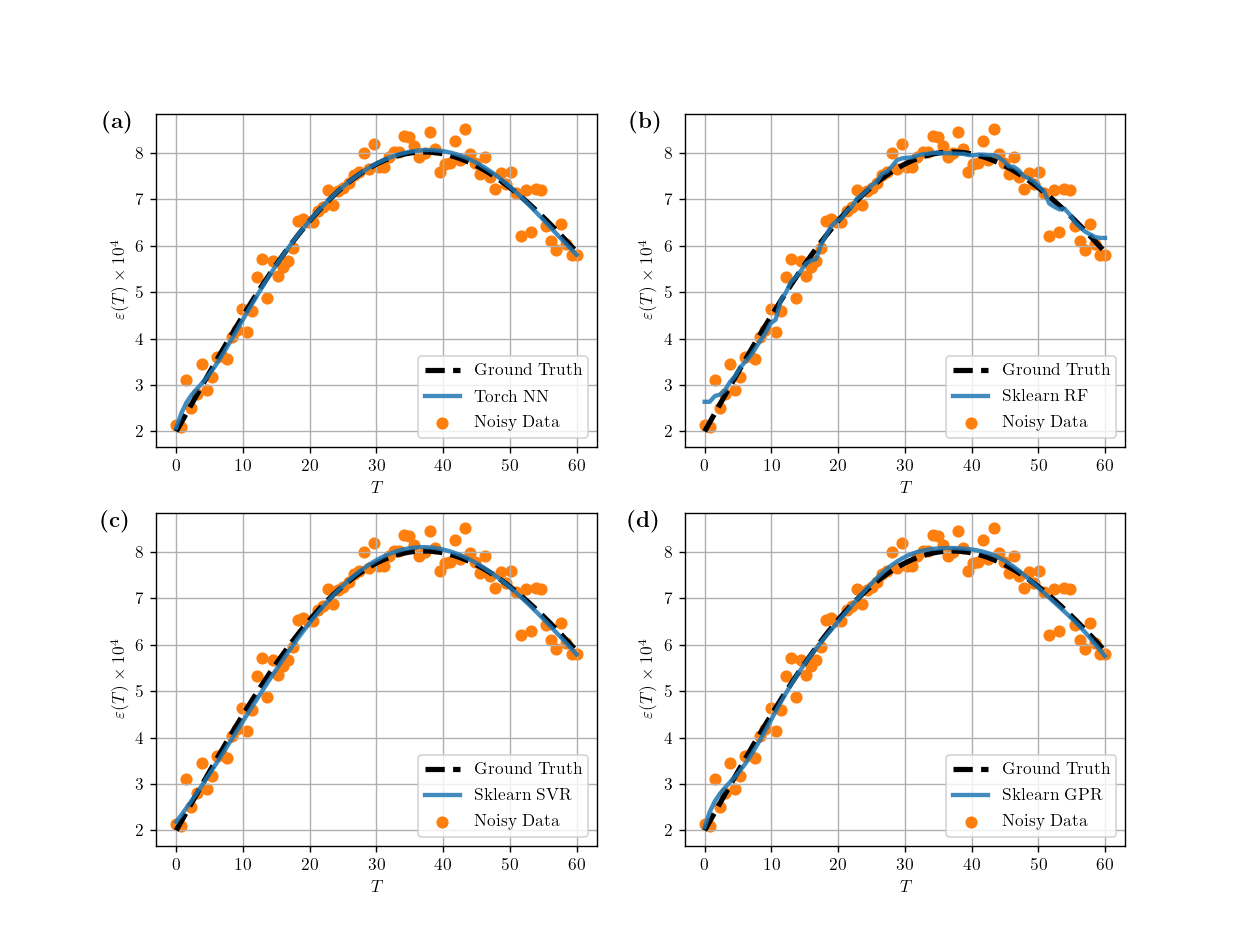

In [324]:
# plot the training data
fig, axs = plt.subplots(2, 2, figsize=(10, 7.6))

l_theo = axs[0][0].plot(X_theo, Y_theo, lw=3, color='k',linestyle='--')
l_ml_NN = axs[0][0].plot(X_theo,pred_onx_NN,lw=2.5, color='C0', alpha=0.85)
l_data_01 = axs[0][0].scatter(X_total,Y_exp,color='C1')
axs[0][0].set_ylabel(r" ${\varepsilon(T)} \times 10^4$ ")
axs[0][0].set_xlabel(r" ${T}$ ")
axs[0][0].legend(handles=[l_theo[0],l_ml_NN[0], l_data_01],
           labels=['Ground Truth','Torch NN', 'Noisy Data'],loc='best')
axs[0][0].grid()


l_theo = axs[0][1].plot(X_theo,Y_theo,lw=3, color='k',linestyle='--')
l_ml_RF = axs[0][1].plot(X_theo,pred_onx_RF,lw=2.5, color='C0', alpha=0.85)
l_data_01 = axs[0][1].scatter(X_total, Y_exp, color='C1')
axs[0][1].set_ylabel(r" ${\varepsilon(T)} \times 10^4$ ")
axs[0][1].set_xlabel(r" ${T}$ ")
axs[0][1].legend(handles=[l_theo[0],l_ml_RF[0], l_data_01],
           labels=['Ground Truth','Sklearn RF', 'Noisy Data'],loc='best')
axs[0][1].grid()

l_theo = axs[1][0].plot(X_theo,Y_theo,lw=3, color='k',linestyle='--')
l_ml_SVR = axs[1][0].plot(X_theo,pred_onx_SVR, lw=2.5, color='C0', alpha=0.85)
l_data_01 = axs[1][0].scatter(X_total,Y_exp,color='C1')
axs[1][0].set_ylabel(r" ${\varepsilon(T)} \times 10^4$ ")
axs[1][0].set_xlabel(r" ${T}$ ")
axs[1][0].legend(handles=[l_theo[0],l_ml_SVR[0], l_data_01],
           labels=['Ground Truth','Sklearn SVR', 'Noisy Data'],loc='best')
axs[1][0].grid()


l_theo = axs[1][1].plot(X_theo,Y_theo,lw=3, color='k',linestyle='--')
l_ml_GPR = axs[1][1].plot(X_theo,pred_onx_GPR,lw=2.5, color='C0', alpha=0.85)
l_data_01 = axs[1][1].scatter(X_total,Y_exp,color='C1')
axs[1][1].set_ylabel(r" ${\varepsilon(T)} \times 10^4$ ")
axs[1][1].set_xlabel(r" ${T}$ ")
axs[1][1].legend(handles=[l_theo[0],l_ml_SVR[0], l_data_01],
           labels=['Ground Truth','Sklearn GPR', 'Noisy Data'],loc='best')
axs[1][1].grid()


Txt_a = axs[0][0].text(-0.09, 0.956, r" $\textbf{(a)}$ ",
                 ha='center', transform=axs[0][0].transAxes, fontsize=13)
Txt_b = axs[0][1].text(-0.09, 0.956, r" $\textbf{(b)}$ ",
                 ha='center', transform=axs[0][1].transAxes, fontsize=13)

Txt_c = axs[1][0].text(-0.09, 0.956, r" $\textbf{(c)}$ ",
                 ha='center', transform=axs[1][0].transAxes, fontsize=13)
Txt_d = axs[1][1].text(-0.09, 0.956, r" $\textbf{(d)}$ ",
                 ha='center', transform=axs[1][1].transAxes, fontsize=13)


plt.savefig('theo_data_ML.pdf', format='pdf', dpi=1000)



In [323]:
print(np.sqrt(np.trapz((Y_exp-Y_theo)**2, X_theo)/60) / (np.trapz(Y_theo, X_theo)/60))
print(np.sqrt(np.trapz((np.squeeze(pred_onx_NN)-Y_theo)**2, X_theo)/60) / (np.trapz(Y_theo, X_theo)/60))
print(np.sqrt(np.trapz((np.squeeze(pred_onx_RF)-Y_theo)**2, X_theo)/60) / (np.trapz(Y_theo, X_theo)/60))
print(np.sqrt(np.trapz((np.squeeze(pred_onx_SVR)-Y_theo)**2, X_theo)/60) / (np.trapz(Y_theo, X_theo)/60))
print(np.sqrt(np.trapz((np.squeeze(pred_onx_GPR)-Y_theo)**2, X_theo)/60) / (np.trapz(Y_theo, X_theo)/60))
# np.sqrt((Y_exp-Y_theo)**2)

0.04548657350779535
0.009942375210165864
0.018934249201022813
0.012231099229699222
0.013501161463560826
